# Complexity Reduction
In this notebook, we introduce the concept of complexity reduction, and the associated subroutines and data structures for performing this kind of analysis in PyBigDFT. To demonstrate this approach, we study a helix of amino acids taken from [here](http://www.ergoscf.org/xyz/gluala.php). In this case, we have just an XYZ file with a bunch of atoms in it, so we have no a priori information about amino acids or how to break down this system.

## Reading in the System
 We'll begin by loading this system in from the XYZ file.

In [46]:
from BigDFT import XYZ
from BigDFT.Fragments import System, Fragment

The data is read into a system class, which is a named collection of molecule fragments. To start, each atom will be its own fragment. 

In [47]:
sys = System()
with XYZ.XYZReader("testfiles/0004.xyz") as ifile:
    for i, at in enumerate(ifile):
        sys["ATOM:"+str(i)] = Fragment([at])

To help this notebook, we can use py3Dmol to visualize our structures.

In [48]:
def display_molecule(sys):
    def gencolor():
        import random
        r = lambda: random.randint(0,255)
        return '#%02X%02X%02X' % (r(),r(),r())
    
    import py3Dmol
        
    xyzview = py3Dmol.view(width=600,height=400)
    
    # To use py3Dmol, we need an XYZ file in string form.  First, the whole system.  
    outstr = str(sum(len(sys[x]) for x in sys)) + " angstroem"
    outstr += "\n\n"
    for frag in sys.values():
        for at in frag:
            outstr += at.sym + " " + " ".join([str(x) for x in at.get_position("angstroem")])
            outstr += "\n"
    xyzview.addModel(outstr)
    xyzview.setStyle({'model': -1}, {'line':{'color': 'black'}})
    
    # Now each fragment (so that we can color it)
    for frag in sys.values():
        outstr = str(len(frag)) + " angstroem\n\n"
        for at in frag:
            outstr += at.sym + " " + " ".join([str(x) for x in at.get_position("angstroem")])
            outstr += "\n"
        xyzview.addModel(outstr)
        xyzview.setStyle({'model': -1}, {'sphere':{'scale':0.15, 'color': gencolor()}})
            
    # Now we can draw the plot
    xyzview.zoomTo()
    xyzview.show()

In [49]:
display_molecule(sys)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Calculations on this System
The next step of a complexity reduction analysis is to perform a linear scaling calculation on this molecule.

In [50]:
from BigDFT.Inputfiles import Inputfile
from BigDFT.Calculators import SystemCalculator

We here setup the input file. The key aspects are the use of the linear scaling mode, and the option to write the support function matrices to file.

In [51]:
inp = Inputfile()
inp.set_xc("PBE")
inp.set_hgrid(0.65) # this is an overly coarse grid, be careful about this in practice.
inp.write_support_function_matrices()
inp["import"] = "linear"

A system calculator for running.

In [52]:
code = SystemCalculator()
code.update_global_options(skip=True)

Initialize a Calculator with OMP_NUM_THREADS=2 and command mpirun -machinefile /var/lib/oar/1884062 /home/wdawson/share/binaries/flake8-nopoly/install/bin/bigdft


And now the calculation can be performed. This calculation takes some time to run.

In [53]:
log = code.run(input=inp, posinp=sys.get_posinp(), name="GluAla")

Creating the yaml input file "./GluAla.yaml"
Executing command:  mpirun -machinefile /var/lib/oar/1884062 /home/wdawson/share/binaries/flake8-nopoly/install/bin/bigdft -n GluAla -s Yes


## Complexity Reduction 1: Breaking Down the System into Fragments
We now move to the actual complexity reduction analysis. The first analysis we will perform will take this molecule, and break it down into chemically meaningful fragments. For this, we will need the BigDFT post processing tool.

In [54]:
from BigDFT.PostProcessing import BigDFTool

In [55]:
btool = BigDFTool()

When we first loaded in our system, we put it into a system class, where every atom was its own named fragment. Using the BigDFTool's purity analysis technique, we can evaluate how good of a fragmentation this is.

In [56]:
pv = btool.run_compute_purity(sys, log)

And then plot those purity values.

In [57]:
from matplotlib import pyplot as plt
from BigDFT.Fragments import plot_fragment_information

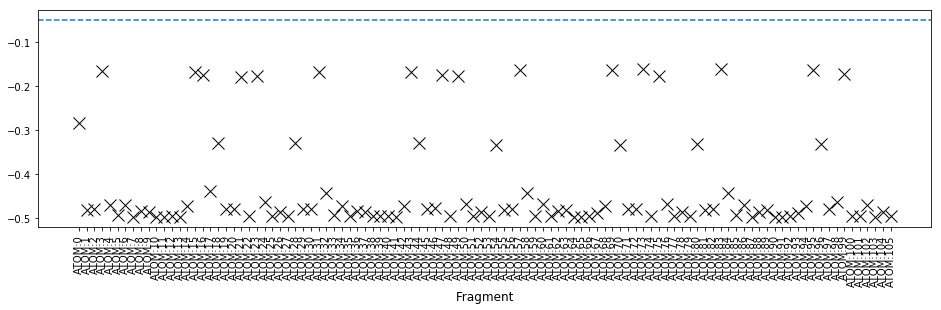

In [58]:
fig, axs = plt.subplots(1,1,figsize=(16,4))
plot_fragment_information(axs, pv)
axs.axhline(-0.05, linestyle='--')

In general, we consider a value above -0.05 to be a good starting point. Obviously, the current fragmentation is not a good way to partition this system. To fix this, we will use the bigdft tool to perform an automatic fragmentation of the system. 

In [59]:
resys = btool.auto_fragment(system=sys, cutoff=0.05, log=log, criteria="bondorder")

We can now plot these new values.

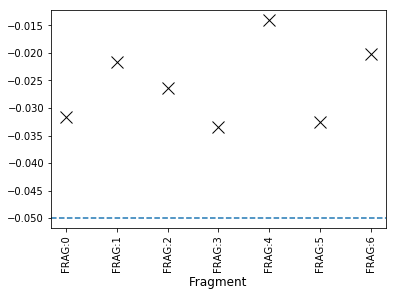

In [60]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
pv = btool.run_compute_purity(resys, log)
plot_fragment_information(axs, pv)
axs.axhline(-0.05, linestyle='--')

We see that the auto fragmentation tool has partitioned this system into just a few fragments. Let's take a look at these fragments.

In [61]:
display_molecule(resys)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Complexity Reduction 2: Examining Fragment Interactions
Next we will look at these fragments, and try to quantify their interactions. This can be done by computing the fragment bond order.

In [62]:
bond_order = btool.fragment_bond_order(resys, resys.keys(), resys.keys(), log)

In [63]:
from pandas import DataFrame

df = []
for fragid, vals in bond_order.items():
    df.append([fragid] + list(vals.values()))
display(DataFrame(df, columns=["Fragid"] + list(bond_order.keys())))

,Fragid,FRAG:4,FRAG:0,FRAG:6,FRAG:5,FRAG:3,FRAG:1,FRAG:2
0,FRAG:4,80.876449,0.015174,0.000001,1.111904,0.002955,0.000661,0.000028
1,FRAG:0,0.011452,65.589385,0.001004,1.040658,1.072517,0.004205,0.000397
2,FRAG:6,0.000001,0.002143,117.869087,0.000686,0.211221,1.182292,1.167008
3,FRAG:5,1.266254,1.106853,0.000460,85.533846,0.141419,0.512742,0.000567
4,FRAG:3,0.004392,1.170115,0.129026,0.232854,85.357447,1.164364,0.494336
5,FRAG:1,0.000981,0.003105,1.084925,0.492695,1.140992,121.492963,0.008970
6,FRAG:2,0.000020,0.000610,1.159425,0.000632,0.431328,0.007821,56.710236


Unsurprisngly, each fragment has a strong interaction with itself. One interesting thing we see here is that each fragment has a different interaction strength with each different fragment. For some the interaction is strong, for others it is weak. We can use this information to generate qm/mm calculations. We will investigate this in regards to trying to reproduce a specific observable: the fragment dipole.

In [64]:
for fragid in resys:
    resys.set_atom_multipoles(log)

In [65]:
df = []
mps = {}
for fragid, frag in resys.items():
    mps[fragid] = frag.d0()
    df.append([fragid] + [x for x in mps[fragid]])
display(DataFrame(df,columns=["Fragid", "Dipole X", "Dipole Y", "Dipole Z"]))

,Fragid,Dipole X,Dipole Y,Dipole Z
0,FRAG:4,-0.243405,0.682638,0.618832
1,FRAG:0,0.804028,-0.736672,-1.041283
2,FRAG:6,-3.976115,-0.579716,0.469371
3,FRAG:5,-2.753171,-0.513823,-2.102887
4,FRAG:3,-3.362412,-0.504306,0.602730
5,FRAG:1,-1.660528,0.723981,0.002910
6,FRAG:2,0.069613,-0.179016,-0.988873


Let's narrow in on the fragment with the largest dipole for this study. 

In [66]:
target = max(mps, key=lambda x: [mps[x][0]**2 + mps[x][1]**2 + mps[x][2]**2])

We will now use the generate qm/mm feature of the bigdft tool to generate different qm/mm regions for study. Note that in a study involving significant inter-fragment charge transfer, you might need to give a fragment a net background charge.

In [67]:
qmmmsys = {}
charges = {}
df = []

cutoffs = [100, 1, 0.1]

for cut in cutoffs:
    qmmmsys[cut], mm = btool.create_qmmm_system(resys, log, target, cut)
    size = sum([len(x) for x in qmmmsys[cut].values()])
    df.append([cut, size])
    
display(DataFrame(df, columns=["Cutoff", "QM Region Size"]))

,Cutoff,QM Region Size
0,100.0,19
1,1.0,51
2,0.1,65


We can use the following subroutine to visualize this qm/mm setup. The target region is in yellow, the buffer region in blue, and the excluded atoms in black.

In [68]:
def display_qmmm(sys, target, buffer):    
    import py3Dmol
        
    xyzview = py3Dmol.view(width=600,height=400)
    
    # To use py3Dmol, we need an XYZ file in string form.  First, the whole system.  
    outstr = str(sum(len(sys[x]) for x in sys)) + " angstroem"
    outstr += "\n\n"
    for frag in sys.values():
        for at in frag:
            outstr += at.sym + " " + " ".join([str(x) for x in at.get_position("angstroem")])
            outstr += "\n"
    xyzview.addModel(outstr)
    xyzview.setStyle({'model': -1}, {'line':{'color': 'black'}})
    
    # Now each fragment
    for fragid, frag in sys.items():
        outstr = str(len(frag)) + " angstroem\n\n"
        for at in frag:
            outstr += at.sym + " " + " ".join([str(x) for x in at.get_position("angstroem")])
            outstr += "\n"
        xyzview.addModel(outstr)
        if fragid == target:
            color = 'yellow'
        elif fragid in buffer:
            color = 'blue'
        else:
            color = 'black'
        xyzview.setStyle({'model': -1}, {'sphere':{'scale':0.15, 'color': color}})
            
    # Now we can draw the plot
    xyzview.zoomTo()
    xyzview.show()

In [69]:
display_qmmm(resys, target, qmmmsys[0.1].keys())

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

With the systems setup, we can now perform the calculations.

In [70]:
qmmm_logs = {}
for cut in cutoffs[:]:
    qmmm_logs[cut] = code.run(input=inp, posinp=qmmmsys[cut].get_posinp(),
                              name="GluAla-"+str(cut))
    qmmmsys[cut].set_atom_multipoles(qmmm_logs[cut])

Creating the yaml input file "./GluAla-100.yaml"
Executing command:  mpirun -machinefile /var/lib/oar/1884062 /home/wdawson/share/binaries/flake8-nopoly/install/bin/bigdft -n GluAla-100 -s Yes
Creating the yaml input file "./GluAla-1.yaml"
Executing command:  mpirun -machinefile /var/lib/oar/1884062 /home/wdawson/share/binaries/flake8-nopoly/install/bin/bigdft -n GluAla-1 -s Yes
Creating the yaml input file "./GluAla-0.1.yaml"
Executing command:  mpirun -machinefile /var/lib/oar/1884062 /home/wdawson/share/binaries/flake8-nopoly/install/bin/bigdft -n GluAla-0.1 -s Yes


And last we can look how the error changes as we modify the cutoff.

In [71]:
from numpy.linalg import norm
from numpy import dot, arccos, pi
df = []

ref_d0 = resys[target].d0()
    
for cut in cutoffs[:]:
    computed_d0 = qmmmsys[cut][target].d0()
    error = norm(computed_d0 - ref_d0) / norm(ref_d0)
    angle = (180/pi) * arccos(dot(computed_d0, ref_d0)/(norm(computed_d0) * norm(ref_d0)))
    df.append([cut, error, angle])
    
display(DataFrame(df, columns=["Cutoff", "Norm Error", "Angle Error"]))

,Cutoff,Norm Error,Angle Error
0,100.0,0.160037,6.807145
1,1.0,0.035854,1.973937
2,0.1,0.062536,3.321515


We see that for this particular case, the value converged very quickly.

In [72]:
display_qmmm(resys, target, qmmmsys[1].keys())

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol